# 1D CNN 코드
- ANNIE 2023.11.24
- Simple CNN Pytorch 구현
- 멘토님 피드백 정리 추가 완료

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 신호 시각화

- 스케일링에서 민맥스는 추천하지 않음
- 정규화 할 때, 표준편차(분모)가 0이 되지 않도록 처리

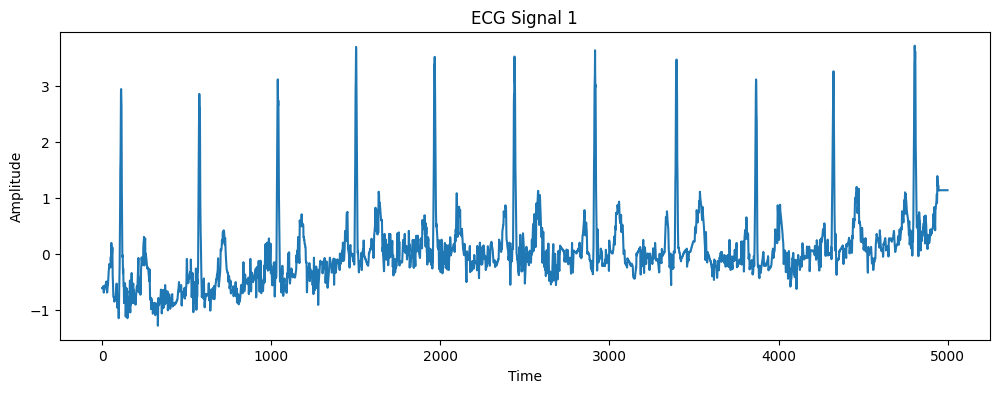

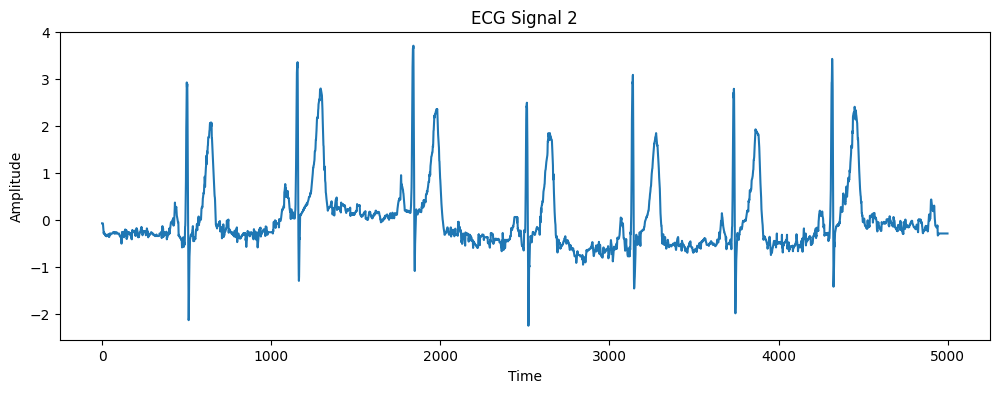

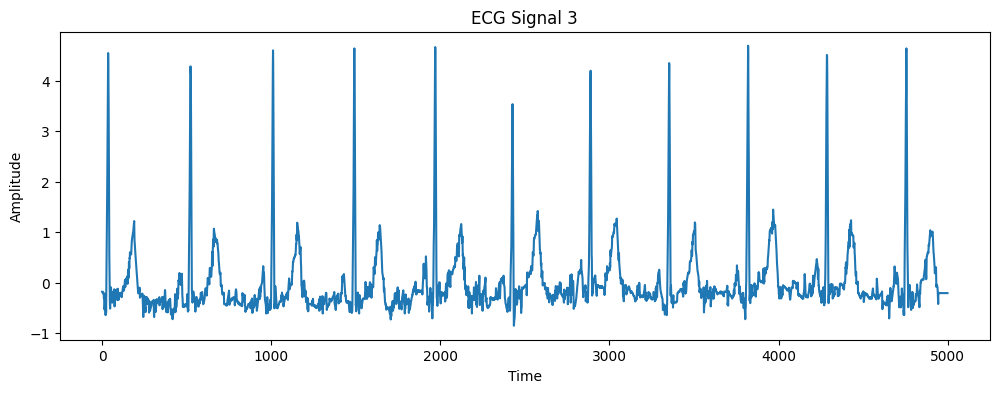

In [3]:
# custom_file 폴더에서 lead1_signals 데이터 로드
lead1_signals = np.load('./custom_file/annie_ptb_xl_lead1.npy')

# 데이터 정규화
lead1_signals_normalized = (lead1_signals - lead1_signals.mean()) / (lead1_signals.std()+1e-7)

# 개별 신호 시각화
def plot_ecg_signal(signal, title="ECG Signal"):
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

# 몇 개의 신호 시각화
for i in range(3):
    plot_ecg_signal(lead1_signals_normalized[i], title=f"ECG Signal {i+1}")


In [4]:
lead1_signals.mean()

-0.0015642019

In [5]:
lead1_signals.std()

0.18565995

# 이상치 확인

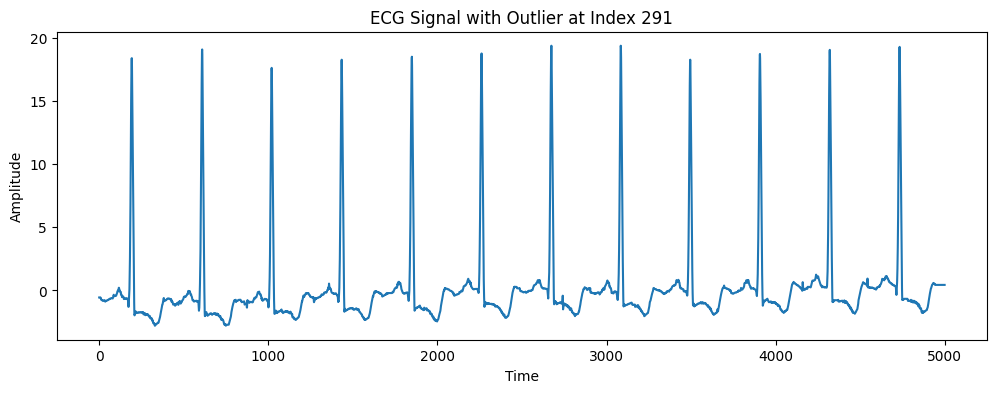

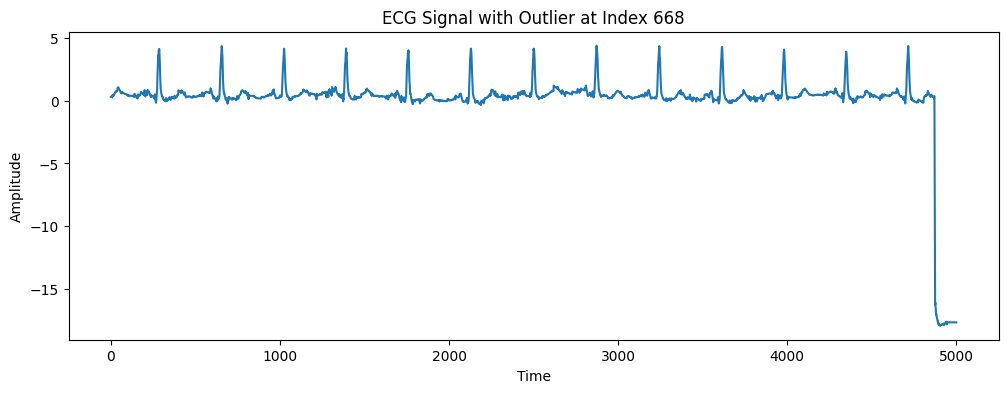

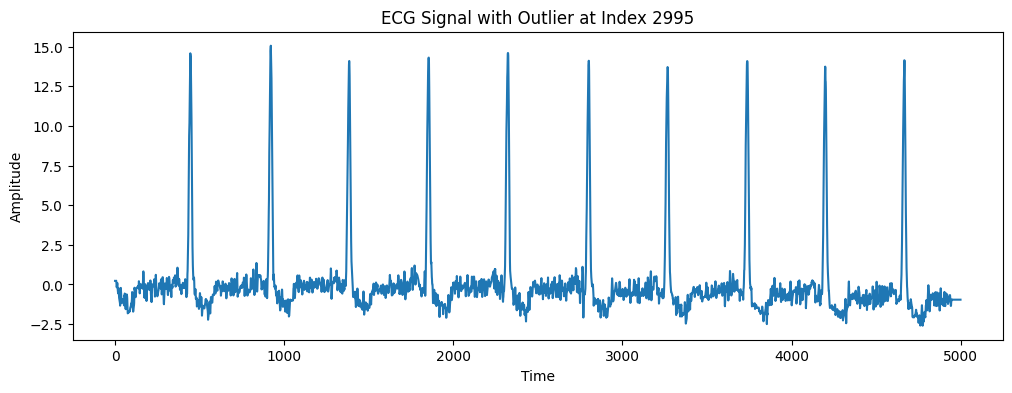

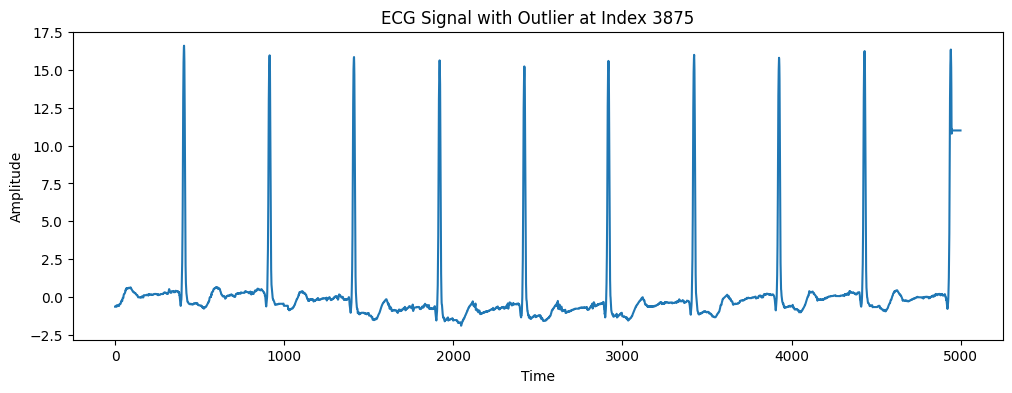

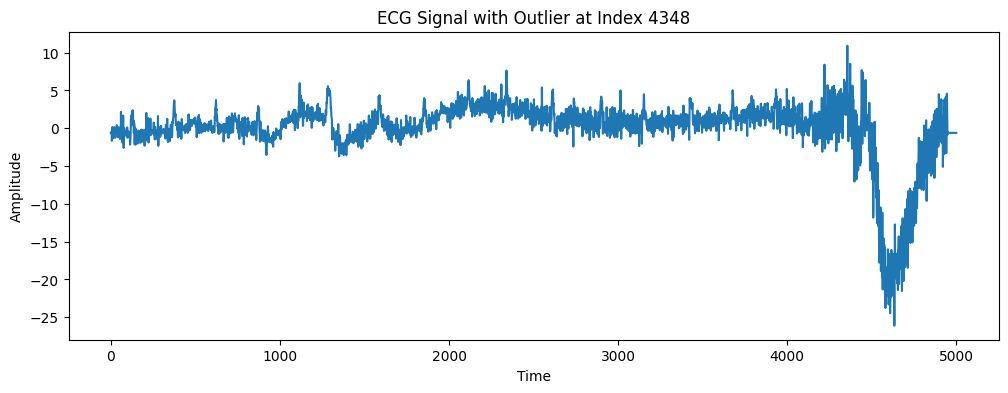

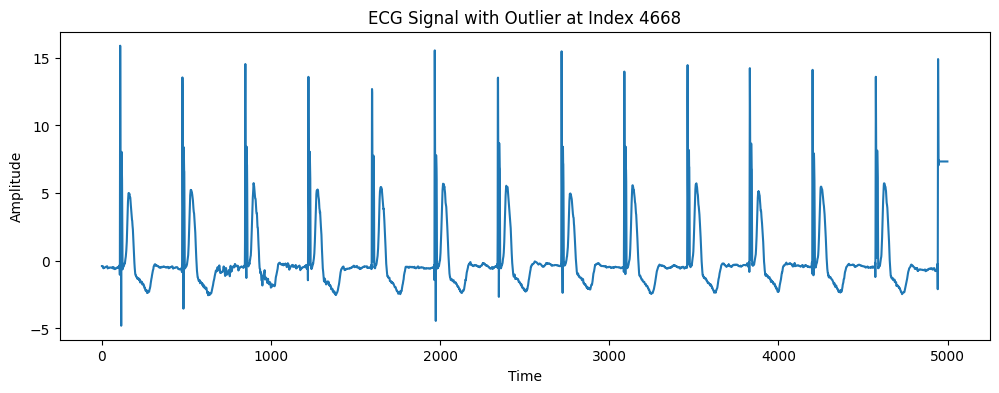

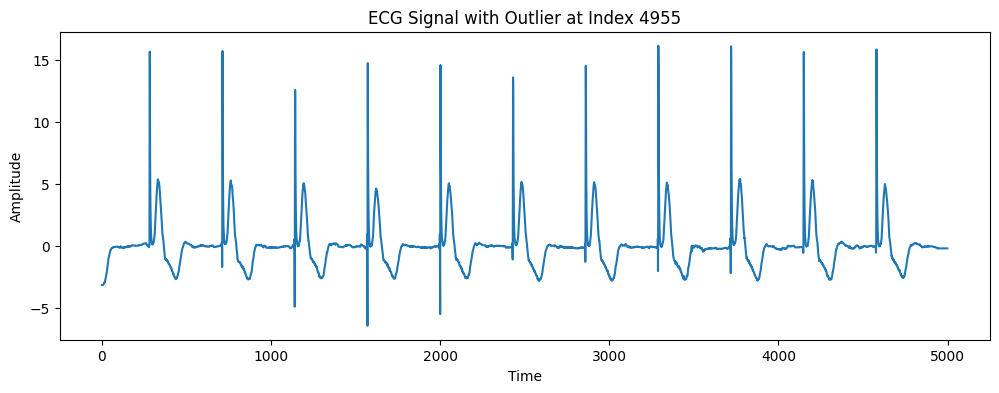

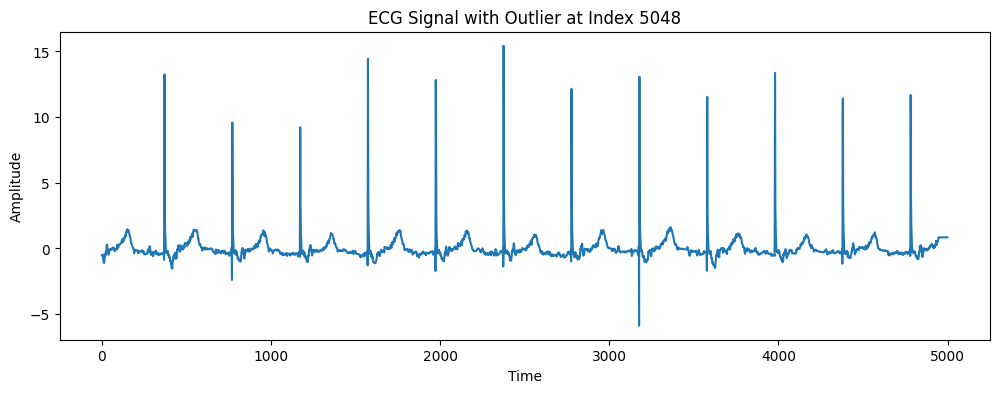

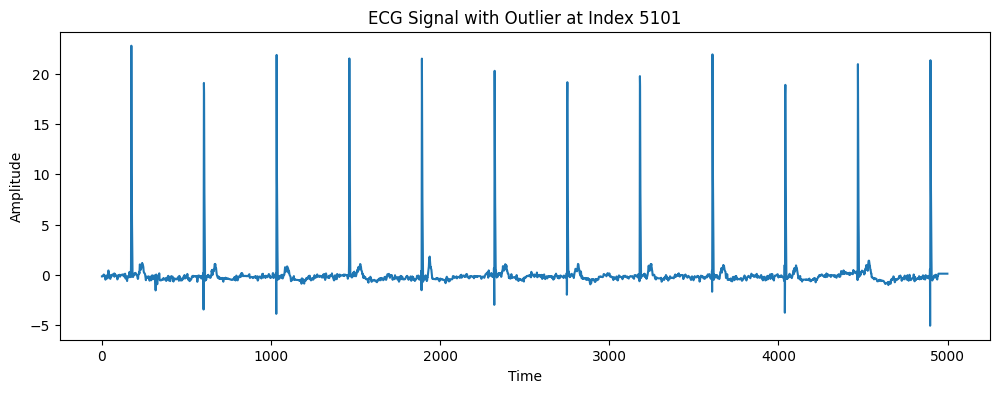

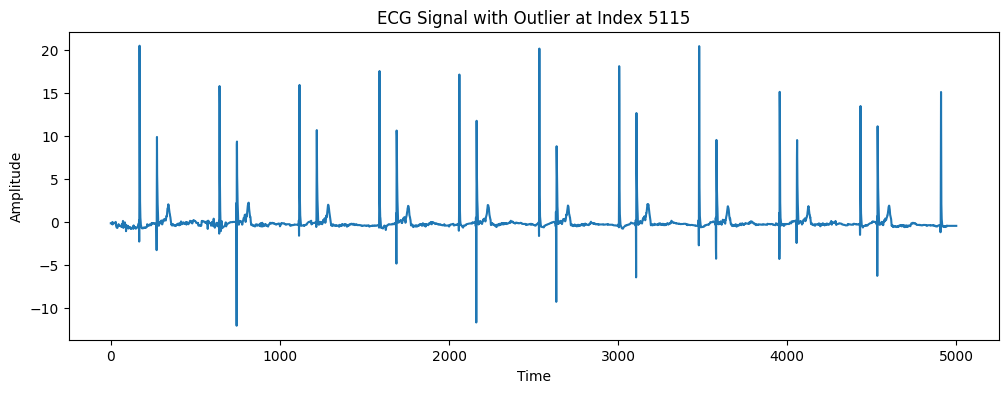

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 이상치 기준 설정
lower_threshold = -15
upper_threshold = 15

# 이상치를 포함하는 행의 인덱스를 찾습니다.
outlier_indices = np.where(
    (lead1_signals_normalized < lower_threshold) | 
    (lead1_signals_normalized > upper_threshold)
)[0]

# 중복된 인덱스를 제거하고, 유니크한 행 인덱스만 가져옵니다.
unique_outlier_indices = np.unique(outlier_indices)

# 신호 시각화 함수 정의
def plot_ecg_signal(signal, title="ECG Signal"):
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

# 각 이상치 행에 대해 심전도 그래프를 그립니다.
for i, index in enumerate(unique_outlier_indices):
    if i >= 10:  # 최대 10개의 이상치 그래프만 그립니다.
        break
    plot_ecg_signal(lead1_signals_normalized[index], title=f"ECG Signal with Outlier at Index {index}")


In [7]:
unique_outlier_indices.size

112

# AFIB 라벨링

In [8]:
df = pd.read_csv('./ptb_xl_data/ptbxl_database.csv', index_col='ecg_id')
df.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [9]:
import ast
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
df.scp_codes = df.scp_codes.apply(lambda x: list(x.keys()))
df.scp_codes

ecg_id
1               [NORM, LVOLT, SR]
2                   [NORM, SBRAD]
3                      [NORM, SR]
4                      [NORM, SR]
5                      [NORM, SR]
                   ...           
21833    [NDT, PVC, VCLVH, STACH]
21834           [NORM, ABQRS, SR]
21835                 [ISCAS, SR]
21836                  [NORM, SR]
21837                  [NORM, SR]
Name: scp_codes, Length: 21799, dtype: object

In [10]:
df['label'] = df.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)
df.label.value_counts()

label
0    20285
1     1514
Name: count, dtype: int64

In [11]:
fold_distribution = df.groupby(['strat_fold', 'label']).size().unstack(fill_value=0)
fold_distribution

label,0,1
strat_fold,,
1,2024,151
2,2030,151
3,2041,151
4,2023,151
5,2022,152
6,2022,151
7,2024,152
8,2021,152
9,2032,151


In [12]:
# 이상치 있는 데이터의 scp_code 확인
a= unique_outlier_indices

for i in a:
    row_with_index = df.loc[i]
    print(row_with_index['scp_codes'])

['NORM', 'IRBBB', 'HVOLT', 'SR']
['NORM', 'SR']
['NORM', 'SR']
['AMI', 'ABQRS', 'SR']
['NORM', 'SR']
['NORM', 'SR']
['NORM']
['ISCAL', 'ISCIN', 'LVH', 'SR']
['NDT', 'LVH', 'SR']
['NORM', 'ABQRS', 'SBRAD']
['ASMI', 'LMI', 'LAO/LAE', 'LPFB', 'ABQRS', 'SR']
['NORM', 'SR']
['ISCIL', 'IVCD', 'LAO/LAE', 'NST_', 'SR']
['NORM', 'SR']
['ASMI', 'IVCD', 'LVH', 'LAFB', 'PAC', 'SR']
['LVH', 'LAO/LAE', 'NST_', 'SR']
['ISCAL', 'SR']
['LMI', 'IPMI', 'PVC', 'AFIB', 'ABQRS']
['NORM', 'ABQRS', 'SR']
['EL', 'STD_', 'SR']
['CLBBB', '1AVB', 'LPR', 'SR']
['ISCAL', 'LVOLT', 'SR']
['LVH', 'VCLVH', 'SR']
['NDT', 'SR']
['IMI', 'ASMI', 'QWAVE', 'SR']
['NDT', 'SR']
['NORM', 'SBRAD']
['IMI', 'ABQRS', 'SR']
['NDT', 'PVC', 'SR']
['IMI', 'ISCAS']
['NORM', 'LPR', 'SR']
['NORM', 'SR']
['NORM', '2AVB', 'SBRAD']
['NORM', 'STACH']
['NORM', 'SR']
['ISCIL', 'SR']
['NORM', 'SR']
['NORM', 'SR']
['CLBBB', 'SR']
['ASMI', 'IVCD', 'SR']
['NORM', 'SR']
['LVH', 'ISC_', 'STACH']
['NORM', 'IVCD', 'SR']
['CLBBB', 'SR']
['IMI', 'ASMI', 

# 모델 구축

- fold 나눌 때, strat_fold는 신경안써도 됌
- 데이터 양이 많다면, 데이터셋을 배치 당 텐서로 만들어서 GPU로 올리는 것을 추천.

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


# custom_file 폴더에서 lead1_signals 데이터 로드
lead1_signals = np.load('./custom_file/annie_ptb_xl_lead1.npy')


# 레이블 데이터 로드
labels = df['label'].values


# 데이터 정규화
lead1_signals_normalized = (lead1_signals - lead1_signals.mean()) / (lead1_signals.std()+1e-7)


# 데이터셋을 텐서로 변환
X = torch.Tensor(lead1_signals_normalized)
Y = torch.Tensor(labels).long()  # 레이블 데이터를 long 타입의 텐서로 변환


# 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


# 채널 수를 1로 추가_GOOD
X_train = X_train.unsqueeze(1)
X_val = X_val.unsqueeze(1)
X_test = X_test.unsqueeze(1)


# DataLoader 생성
train_data = TensorDataset(X_train, Y_train)
val_data = TensorDataset(X_val, Y_val)
test_data = TensorDataset(X_test, Y_test)

batch_size = 64
# 마지막 불완전한 배치를 버림(drop_last는 없어야 함)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


# 간단한 CNN 모델 구축
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, 32, kernel_size=5, stride=1) #output 4996
        self.pool = torch.nn.MaxPool1d(kernel_size=2, stride=2) # 2498
        self.conv2 = torch.nn.Conv1d(32, 64, kernel_size=5) # 2494
        self.fc1 = torch.nn.Linear(64 * 1247, 1000) 
        self.fc2 = torch.nn.Linear(1000, 500)
        self.fc3 = torch.nn.Linear(500, 1)  # 클래스가 2개이므로 출력 크기를 2로 설정

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 1247)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

- 커널 사이즈 다양하게, 스트라이드(1~3) 사이로 실험 해보기
- 마지막 fc3 함수를 시그모이드나 소프트맥스 함수도 가능하다

# 모델학습

- 모델 돌릴 때, 시드가 정해져있어야 함. iteration마다 성능이 동일하게 나오는 지 확인하자.
- 성능 좋은 모델 저장하는 코드 추가 요망_어떤 기준? auroc로 val 계산 후 가장 높은 값을 가진 모델을 저장하게끔.
    - 이진분류기 때문에 auroc로 모니터링 추천


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns


# 모델을 GPU로 옮기기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# 손실 함수 정의 (이진 크로스 엔트로피)
criterion = torch.nn.BCEWithLogitsLoss() # 시그모이드가 포함되어있음!

# 옵티마이저 선택 (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 학습 및 검증 손실과 정확도를 기록할 리스트
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


# 학습 루프 설정
num_epochs = 10
for epoch in range(num_epochs):
    # 훈련 데이터 루프
    model.train()
    train_accuracy = 0
    train_loss = 0.0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
        optimizer.zero_grad()  # 그래디언트 초기화

        # 순전파 및 역전파
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy / total)

    # 검증 데이터 루프
    model.eval()
    val_preds = []
    val_targets = []
    val_loss = 0.0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            val_loss += loss.item()
            val_preds.extend(outputs.view(-1).cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_targets, np.round(val_preds))
    val_auroc = roc_auc_score(val_targets, val_preds)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # 에포크의 결과 출력
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation AUROC: {val_auroc:.4f}')

# 테스트 데이터 루프
model.eval()
test_accuracy = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc=f"Testing"):
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

test_accuracy /= len(test_loader.dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10 - Training: 100%|██████████| 205/205 [00:08<00:00, 24.74it/s]


Epoch [1/10] - Validation Loss: 0.2441 - Validation Accuracy: 0.0000 - Validation AUROC: 0.6797


Epoch 2/10 - Training: 100%|██████████| 205/205 [00:08<00:00, 24.72it/s]


Epoch [2/10] - Validation Loss: 0.2538 - Validation Accuracy: 0.0000 - Validation AUROC: 0.6587


Epoch 3/10 - Training: 100%|██████████| 205/205 [00:08<00:00, 24.63it/s]


Epoch [3/10] - Validation Loss: 0.2418 - Validation Accuracy: 0.0000 - Validation AUROC: 0.6769


Epoch 4/10 - Training: 100%|██████████| 205/205 [00:08<00:00, 24.49it/s]


Epoch [4/10] - Validation Loss: 0.2518 - Validation Accuracy: 0.0000 - Validation AUROC: 0.4973


Epoch 5/10 - Training: 100%|██████████| 205/205 [00:08<00:00, 24.55it/s]


Epoch [5/10] - Validation Loss: 0.2522 - Validation Accuracy: 0.0000 - Validation AUROC: 0.5000


Epoch 6/10 - Training: 100%|██████████| 205/205 [00:08<00:00, 24.40it/s]


Epoch [6/10] - Validation Loss: 0.2520 - Validation Accuracy: 0.0000 - Validation AUROC: 0.5000


Epoch 7/10 - Training: 100%|██████████| 205/205 [00:08<00:00, 24.38it/s]


Epoch [7/10] - Validation Loss: 0.2544 - Validation Accuracy: 0.0000 - Validation AUROC: 0.5027


Epoch 8/10 - Training: 100%|██████████| 205/205 [00:08<00:00, 24.45it/s]


Epoch [8/10] - Validation Loss: 0.2523 - Validation Accuracy: 0.0000 - Validation AUROC: 0.5000


Epoch 9/10 - Training: 100%|██████████| 205/205 [00:08<00:00, 24.13it/s]


Epoch [9/10] - Validation Loss: 0.2519 - Validation Accuracy: 0.0000 - Validation AUROC: 0.5000


Epoch 10/10 - Training: 100%|██████████| 205/205 [00:08<00:00, 24.54it/s]


Epoch [10/10] - Validation Loss: 0.2519 - Validation Accuracy: 0.0000 - Validation AUROC: 0.5000


Testing: 100%|██████████| 69/69 [00:00<00:00, 128.16it/s]

Test Accuracy: 93.33%


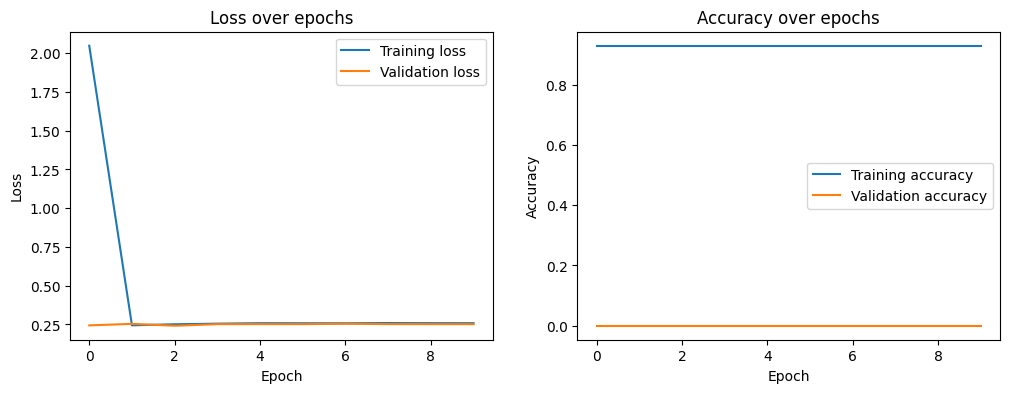

In [38]:
# 손실 그래프 그리기
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## confusion matrix
- threshold 에 따라 달라질 수 있음.
- youden index 가 가장 높게 나오는 모델 선택해보고 CM 관찰하기

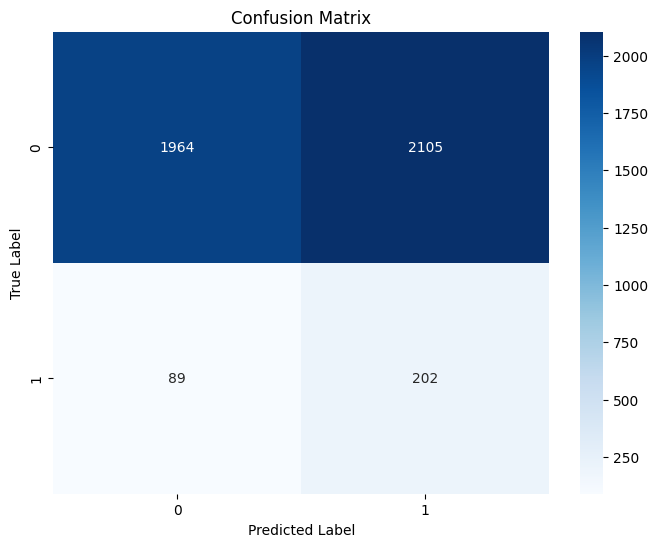

Accuracy: 0.4968
Precision: 0.0876
Recall: 0.6942
F1 Score: 0.1555


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# 모델을 평가 모드로 설정
model.eval()

# 모든 예측과 레이블을 저장할 리스트 초기화
all_predictions = []
all_labels = []

# 테스트 데이터에 대한 예측 수행
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).view(-1)  # 시그모이드 함수 적용
        predicted = (probs > 9.716244e-09).long()  # youden index 이용
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
# 성능 지표 계산
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# 혼동 행렬 생성
cm = confusion_matrix(all_labels, all_predictions)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 성능 지표 출력
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

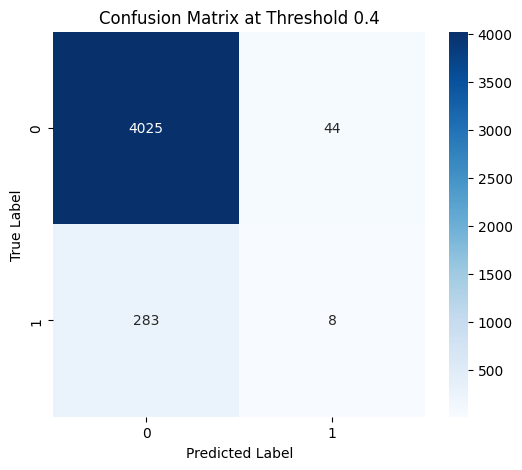

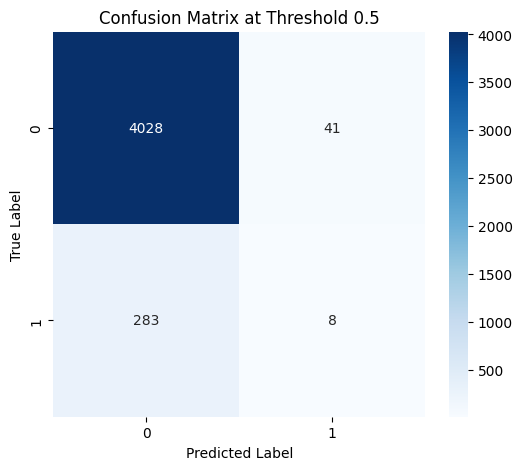

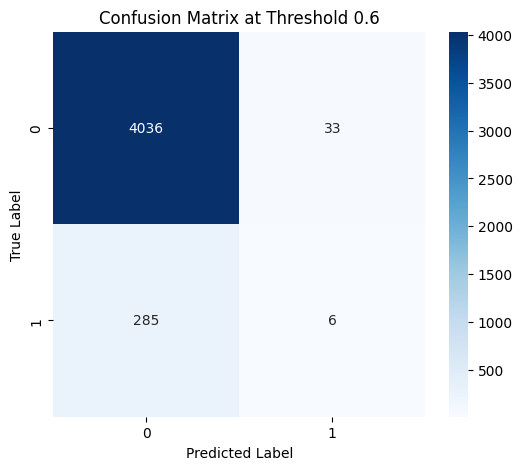

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# 모델을 평가 모드로 설정
model.eval()

# 예측 확률을 저장할 리스트
all_preds_probs = []

# 테스트 데이터에 대한 예측 확률 수행
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()  # 확률 계산
        all_preds_probs.extend(probs)

# 다양한 임계값에 대해 confusion matrix 계산
thresholds = [0.4, 0.5, 0.6]  # 임계값 예시
for threshold in thresholds:
    # 임계값을 적용하여 예측 레이블 결정
    predicted_labels = [1 if prob > threshold else 0 for prob in all_preds_probs]
    cm = confusion_matrix(all_labels, predicted_labels)

    # Confusion matrix 시각화
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix at Threshold {threshold}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [31]:
from sklearn.metrics import roc_curve

# 예측 확률과 실제 레이블을 사용하여 ROC 커브 계산
fpr, tpr, thresholds = roc_curve(all_labels, all_preds_probs)

# Youden의 지수 계산
youden_index = tpr - fpr

# 최대 Youden 지수를 가진 임계값 찾기
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", optimal_threshold)

Optimal Threshold: 9.716244e-09


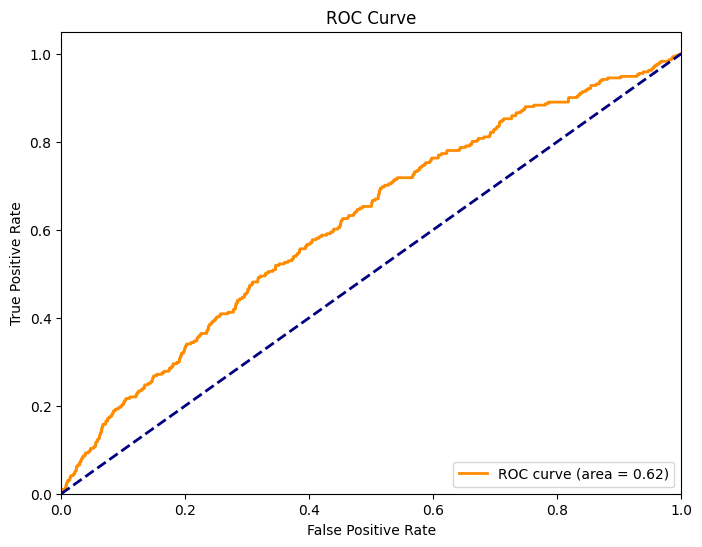

AUROC: 0.62


In [33]:
# 예측 확률을 저장할 리스트
all_preds_probs = []

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터에 대한 예측 확률 수행
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        # sigmoid를 사용하여 확률을 계산
        probs = torch.sigmoid(outputs)
        all_preds_probs.extend(probs.cpu().numpy())

# 실제 레이블과 예측 확률을 사용하여 ROC 커브 계산
fpr, tpr, _ = roc_curve(all_labels, all_preds_probs)
roc_auc = auc(fpr, tpr)

# AUROC 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# AUROC 점수를 출력합니다.
print(f'AUROC: {roc_auc:.2f}')


- 최종 발표 때는 0.95 만들어가기
- 학습 코드 작성 시 주피터 사용 지양 -> train.py 등
- 1D Resnet. 기존의 코드의 레이어를 보고 공부하는 방법을 깃헙에서 찾아서 공부해보기.